In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import urllib.request
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# Load dataset from Johns Hopkins website
def load_url_as_df(url):
    """Loads csv data from a remote URL as a pandas Dataframe"""
    
    with urllib.request.urlopen(url) as stream:
        return pd.read_csv(stream, index_col='Country/Region')

In [3]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df_confirmed = load_url_as_df(url)
df_confirmed.head()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Thailand,NaN,15.0000,101.0000,2,3,5,7,8,8,14,...,50,50,50,53,59,70,75,82,114,147
Japan,NaN,36.0000,138.0000,2,1,2,2,4,4,7,...,461,502,511,581,639,639,701,773,839,825
Singapore,NaN,1.2833,103.8333,0,1,3,3,4,5,7,...,138,150,150,160,178,178,200,212,226,243
Nepal,NaN,28.1667,84.2500,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Malaysia,NaN,2.5000,112.5000,0,0,0,3,4,4,4,...,93,99,117,129,149,149,197,238,428,566


In [4]:
class TimeSeries:
    """TimeSeries
    
    Parameters
    ----------
    tseries: 1D array,
        the time-series as a 1D array
    t_origin: int,
        the time-stamp for the origin of the time-series. Default: 54
    
    Attributes
    ----------
    change_ratio: 1D array, length of tseries - 1
        the value of the time-series on given day, divided by value on day -1.
        mode: {'cumulative','cumulative_smooth'} controls whether change_ratio 
            is applied on raw or smoothed time-series
    smooth: 1D array
        LOWESS smoothed time-series.
        frac: 0.15 (default)
        it  : 0    (default)
    """
    def __init__(self, tseries, t_origin=54):
        self.tseries = tseries
        self.tstamps = np.arange(t_origin, tseries.shape[0]+t_origin)
        
    def change_ratio(self, mode='cumulative'):
        """change_ratio: value today divided by value yesterday
        Arguments:
        =========
        mode: - cumulative (default) uses the input cumulative time-series
              - cumulative_smooth first smoothes the input cumulative time-series
        """
        if(mode=='cumulative'):
            data = self.tseries
        elif(mode=='cumulative_smooth'):
            data = self.smooth()
        today = np.copy(data)[1:]
        yesterday = np.copy(data[np.arange(data.size-1)])
        return today/yesterday
    
    def smooth(self, frac=0.15, it=0): 
        """smoothen a time-series using LOWESS
        https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
        """
        tseries_smooth = lowess(self.tseries, self.tstamps, frac=frac, it=it)
        return tseries_smooth[:,1]

In [7]:
# Focus on one time-series: the worlwide cumulative total
confirmed_total = df_confirmed.sum()
#
ts_confirmed_total   = TimeSeries(confirmed_total.values)
tstamps              = ts_confirmed_total.tstamps
tseries              = ts_confirmed_total.tseries
tseries_smoothened   = ts_confirmed_total.smooth()
tseries_change_ratio = ts_confirmed_total.change_ratio()
smooth_change_ratio  = ts_confirmed_total.change_ratio(mode='cumulative_smooth')

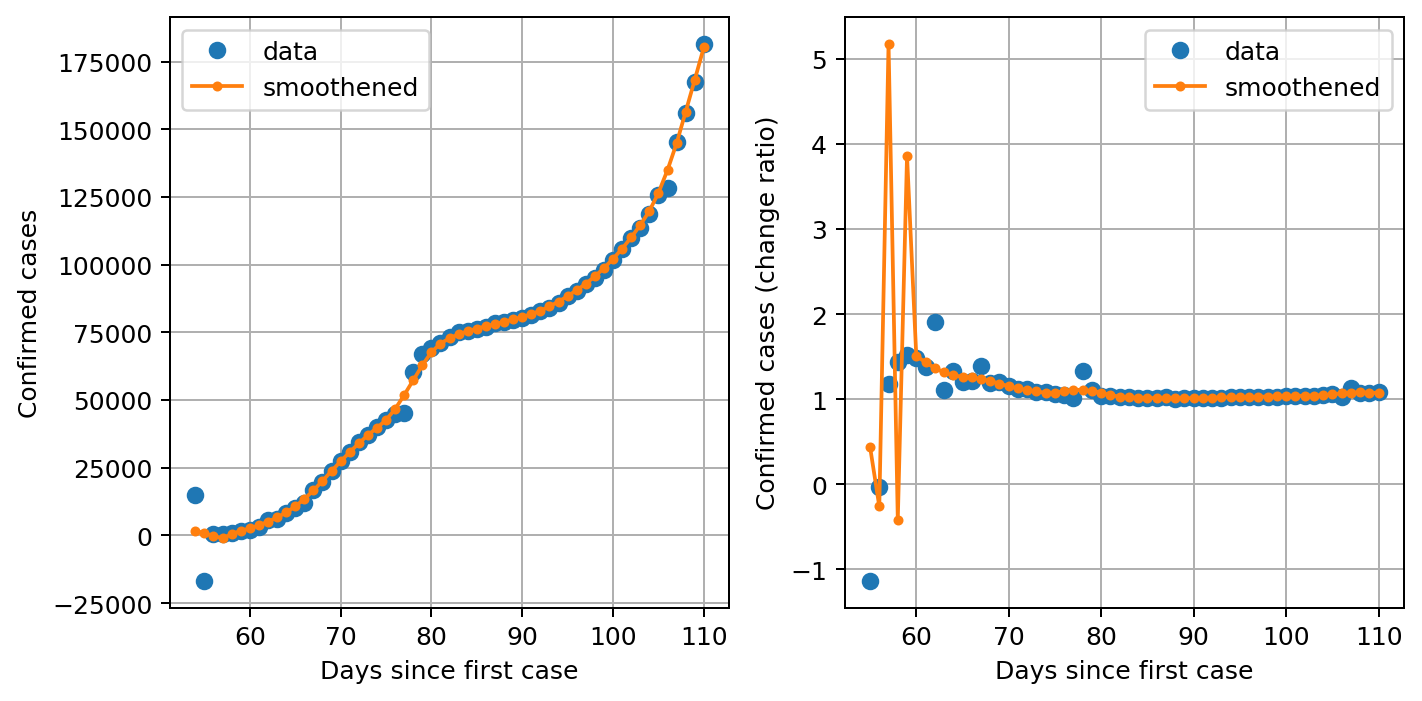

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=180)
ax1.plot(tstamps, tseries, 'o', label='data', )
ax1.plot(tstamps, tseries_smoothened, '.-', label='smoothened')
ax1.set_xlabel('Days since first case')
ax1.set_ylabel('Confirmed cases')
ax1.grid()
ax1.legend()
ax2.plot(tstamps[1:], tseries_change_ratio, 'o', label='data', )
ax2.plot(tstamps[1:], smooth_change_ratio, '.-', label='smoothened')
ax2.set_xlabel('Days since first case')
ax2.set_ylabel('Confirmed cases (change ratio)')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.show()